In [1]:
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt

--2026-01-13 21:37:17--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22322605 (21M) [text/plain]
Saving to: ‘Compiled_Reviews.txt’

Compiled_Reviews.tx 100%[===================>]  21.29M  55.2MB/s    in 0.4s    

2026-01-13 21:37:19 (55.2 MB/s) - ‘Compiled_Reviews.txt’ saved [22322605/22322605]



In [2]:
reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Compiled_Reviews.txt") as f:
   for line in f.readlines()[1:]:
        fields = line.rstrip().split('\t')
        reviews.append(fields[0])
        sentiment_ratings.append(fields[1])
        product_types.append(fields[2])
        helpfulness_ratings.append(fields[3])


In [3]:
selected_type = 'baby'  # choose baby type
filtered_reviews = []
filtered_sentiments = []

for i in range(len(reviews)):
    if product_types[i] == selected_type and helpfulness_ratings[i] in ['helpful', 'neutral']:
        filtered_reviews.append(reviews[i])
        filtered_sentiments.append(sentiment_ratings[i])

print(f"total reviews number:{len(filtered_reviews)}")


total reviews number:1717


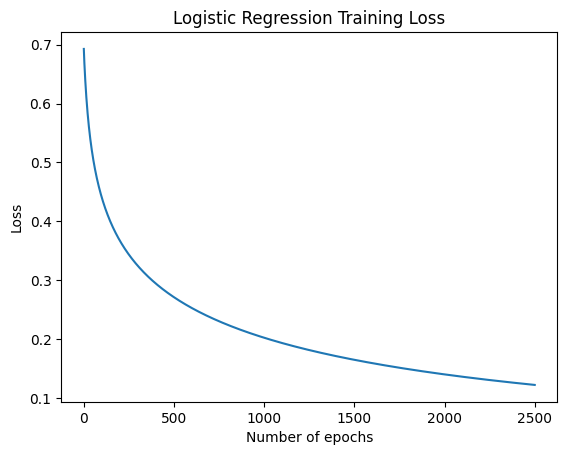

Validation results:
Total validation samples: 344
Accuracy: 0.7877906976744186


In [4]:
import numpy as np
import re
from collections import Counter
import random
import matplotlib.pyplot as plt

#deal with the text and vectorisation
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    stopwords = {
        'the','and','is','in','it','this','that','a','an','of','to','for',
        'with','on','was','were','are','be','have','has','had','i','you',
        'they','we','he','she','my','your'
    }  # the stop word is excluded useless word
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

# Split train and validation data
indices = np.arange(len(filtered_reviews))
np.random.shuffle(indices)

shuffled_reviews = [filtered_reviews[i] for i in indices]
shuffled_sentiments = [filtered_sentiments[i] for i in indices]

split = int(0.8 * len(shuffled_reviews))
train_reviews = shuffled_reviews[:split]
train_sentiments = shuffled_sentiments[:split]
val_reviews = shuffled_reviews[split:]
val_sentiments = shuffled_sentiments[split:]

# Count token frequencies in the training set
token_counter = Counter()
for review in train_reviews:
    token_counter.update(clean_text(review))

# Keep only tokens that appear at least 5 times
vocab_filtered = [word for word, count in token_counter.items() if count >= 5]

# Create word to index mapping
word_to_index = {word: i for i, word in enumerate(vocab_filtered)}

def vectorize(review):
    vec = np.zeros(len(word_to_index))
    for word in clean_text(review):
        if word in word_to_index:
            vec[word_to_index[word]] += 1
    return vec

# Encode sentiment labels
def encode_sentiment(label):
    return np.array([1, 0]) if label == 'positive' else np.array([0, 1])

# Vectorisation
X_train = np.array([vectorize(r) for r in train_reviews])
Y_train = np.array([encode_sentiment(s) for s in train_sentiments])
X_val = np.array([vectorize(r) for r in val_reviews])
Y_val = np.array([encode_sentiment(s) for s in val_sentiments])

# Initialization logistic regression
num_features = X_train.shape[1]
y = np.array([int(l == "positive") for l in train_sentiments])  # 1 = positive,0 = negative
weights = np.random.rand(num_features) * 0.01
bias = 0.0
n_iters = 2500
lr = 0.1
logistic_loss = []
num_samples = len(y)

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Gradient descent training loop
for i in range(n_iters):
    z = np.dot(X_train, weights) + bias
    q = sigmoid(z)
    eps = 0.00001
    loss = -np.sum(y * np.log(q + eps) + (1 - y) * np.log(1 - q + eps)) / num_samples
    logistic_loss.append(loss)

    y_pred = (q >= 0.6).astype(int)

    dz = q - y
    dw = np.dot(X_train.T, dz) / num_samples
    db = np.sum(dz) / num_samples
    weights -= lr * dw
    bias -= lr * db

# Plot training loss
plt.plot(range(1, n_iters + 1), logistic_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Logistic Regression Training Loss")
plt.show()

# Validation set evaluation
y_val = np.array([int(l == "positive") for l in val_sentiments])
z_val = np.dot(X_val, weights) + bias
q_val = sigmoid(z_val)
y_val_pred = (q_val >= 0.6).astype(int)

# Confusion matrix
TP = np.sum((y_val == 1) & (y_val_pred == 1))
TN = np.sum((y_val == 0) & (y_val_pred == 0))
FP = np.sum((y_val == 0) & (y_val_pred == 1))
FN = np.sum((y_val == 1) & (y_val_pred == 0))

accuracy = (TP + TN) / (TP + FP + TN + FN)

print("Validation results:")
print(f"Total validation samples: {len(y_val)}")

#print("\nConfusion Matrix:")
#print(f"TP: {TP}, FN: {FN}")
#print(f"FP: {FP}, TN: {TN}")

print(f"Accuracy: {accuracy}")


In [5]:
import numpy as np
import re
from collections import Counter
import random
import matplotlib.pyplot as plt

# Number of runs to average accuracy
num_runs = 5
accuracy_list = []

for run in range(num_runs):
    #deal with the text and vectorisation
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        stopwords = {
            'the','and','is','in','it','this','that','a','an','of','to','for',
            'with','on','was','were','are','be','have','has','had','i','you',
            'they','we','he','she','my','your'
        }  # the stop word is excluded useless word
        tokens = [t for t in tokens if t not in stopwords]
        return tokens

    # Split train and validation data
    indices = np.arange(len(filtered_reviews))
    np.random.shuffle(indices)

    shuffled_reviews = [filtered_reviews[i] for i in indices]
    shuffled_sentiments = [filtered_sentiments[i] for i in indices]

    split = int(0.8 * len(shuffled_reviews))
    train_reviews = shuffled_reviews[:split]
    train_sentiments = shuffled_sentiments[:split]
    val_reviews = shuffled_reviews[split:]
    val_sentiments = shuffled_sentiments[split:]

    # Count token frequencies in the training set
    token_counter = Counter()
    for review in train_reviews:
        token_counter.update(clean_text(review))

    # Keep only tokens that appear at least 5 times
    vocab_filtered = [word for word, count in token_counter.items() if count >= 5]

    # Create word to index mapping
    word_to_index = {word: i for i, word in enumerate(vocab_filtered)}

    def vectorize(review):
        vec = np.zeros(len(word_to_index))
        for word in clean_text(review):
            if word in word_to_index:
                vec[word_to_index[word]] += 1
        return vec

    # Encode sentiment labels
    def encode_sentiment(label):
        return np.array([1, 0]) if label == 'positive' else np.array([0, 1])

    # Vectorisation
    X_train = np.array([vectorize(r) for r in train_reviews])
    Y_train = np.array([encode_sentiment(s) for s in train_sentiments])
    X_val = np.array([vectorize(r) for r in val_reviews])
    Y_val = np.array([encode_sentiment(s) for s in val_sentiments])

    # Initialization logistic regression
    num_features = X_train.shape[1]
    y = np.array([int(l == "positive") for l in train_sentiments])  # 1 = positive,0 = negative
    weights = np.random.rand(num_features) * 0.01
    bias = 0.0
    n_iters = 2500
    lr = 0.1
    logistic_loss = []
    num_samples = len(y)

    # Sigmoid function
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    # Gradient descent training loop
    for i in range(n_iters):
        z = np.dot(X_train, weights) + bias
        q = sigmoid(z)
        eps = 0.00001
        loss = -np.sum(y * np.log(q + eps) + (1 - y) * np.log(1 - q + eps)) / num_samples
        logistic_loss.append(loss)

        y_pred = (q >= 0.6).astype(int)

        dz = q - y
        dw = np.dot(X_train.T, dz) / num_samples
        db = np.sum(dz) / num_samples
        weights -= lr * dw
        bias -= lr * db

    # Validation set evaluation
    y_val = np.array([int(l == "positive") for l in val_sentiments])
    z_val = np.dot(X_val, weights) + bias
    q_val = sigmoid(z_val)
    y_val_pred = (q_val >= 0.6).astype(int)

    # Confusion matrix
    TP = np.sum((y_val == 1) & (y_val_pred == 1))
    TN = np.sum((y_val == 0) & (y_val_pred == 0))
    FP = np.sum((y_val == 0) & (y_val_pred == 1))
    FN = np.sum((y_val == 1) & (y_val_pred == 0))

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    accuracy_list.append(accuracy)
    print(f"Run {run+1}: Accuracy = {accuracy:.4f}")

# Print average and standard deviation
mean_acc = np.mean(accuracy_list)
std_acc = np.std(accuracy_list)
print(f"\nAverage Accuracy over {num_runs} runs: {mean_acc:.4f} ± {std_acc:.4f}")

Run 1: Accuracy = 0.8488
Run 2: Accuracy = 0.8488
Run 3: Accuracy = 0.8081
Run 4: Accuracy = 0.8314
Run 5: Accuracy = 0.8285

Average Accuracy over 5 runs: 0.8331 ± 0.0151
